In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import PIL
import os

torch.cuda.set_device(1)

TOTAL_BATCH_SIZE = 540
MINI_BATCH_SIZE = 10
LR = 0.005
show_every = False


In [2]:

dir_path = "data/"

dataset_x = np.zeros([TOTAL_BATCH_SIZE, 100, 100])
dataset_y = np.zeros([TOTAL_BATCH_SIZE, 100, 100])

for i in range(TOTAL_BATCH_SIZE):
    img_ori = cv2.imread(dir_path+str(i+1)+"original.jpg")
    img_ori = cv2.resize(img_ori, (100, 100), interpolation = cv2.INTER_CUBIC)
    img_moire = cv2.imread(dir_path+str(i+1)+"moire.jpg")
    img_moire = cv2.resize(img_moire, (100, 100), interpolation = cv2.INTER_CUBIC)
    # img_moire = img_moire / np.average(img_moire) * np.average(img_ori)

    #plt.imshow((img_ori[: ,: , 0] + img_ori[: ,: , 1] + img_ori[: ,: , 2])/3)
    #plt.show()
    #plt.imshow((img_moire[: ,: , 0] + img_moire[: ,: , 1] + img_moire[: ,: , 2])/3)
    #plt.show()

    dataset_y[i, :, :] = cv2.cvtColor(img_ori, cv2.COLOR_RGB2GRAY)
    dataset_x[i, :, :] = cv2.cvtColor(img_moire, cv2.COLOR_RGB2GRAY)

test_x = torch.unsqueeze(torch.tensor(dataset_x), dim=1).type(torch.cuda.FloatTensor)
test_y = torch.unsqueeze(torch.tensor(dataset_y), dim=1).type(torch.cuda.FloatTensor)

print("data fetched")

data fetched


In [3]:
test_img = test_x[5].cpu().data.numpy().squeeze()
print(test_img)
print(cv2.cvtColor(cv2.imread(dir_path+str(5)+"original.jpg"), cv2.COLOR_RGB2GRAY))

[[176. 167. 169. ...  99. 101.  44.]
 [175. 161. 170. ...  91.  72.  40.]
 [167. 162. 179. ...  58.  40.  41.]
 ...
 [166. 156. 140. ... 109.  75.  58.]
 [162. 146. 134. ...  76.  61.  74.]
 [158. 140. 131. ...  69.  48.  68.]]
[[125 124 125 ... 126  82  68]
 [121 122 122 ...  86  69  68]
 [122 121 121 ...  70  68  68]
 ...
 [102 102 113 ... 114 118 116]
 [102 102 109 ... 110 113 111]
 [106 104 107 ... 106 110 108]]


In [4]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU()
        )
        self.down2 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential( 
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU()
        )
        self.up2 = nn.UpsamplingBilinear2d(size=(100, 100))
        
        self.down3 = nn.MaxPool2d(4)
        self.conv3 = nn.Sequential( 
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU()
        )
        self.up3 = nn.UpsamplingBilinear2d(size=(100, 100))
        
        self.down4 = nn.MaxPool2d(8)
        self.conv4 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 2),
            nn.ReLU()
        )
        self.up4 = nn.UpsamplingBilinear2d(size=(100, 100))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(16, 1, 5, 1, 2),
            nn.ReLU()
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.up2(self.conv2(self.down2(x)))
        x3 = self.up3(self.conv3(self.down3(x)))
        x4 = self.up4(self.conv4(self.down4(x)))
        x_sum = x1 + x2 + x3 + x4
        output = self.conv_out(x_sum)
        #output = self.out(x)
        return output

cnn = CNN()
print(cnn)

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

cnn.cuda()
loss_func.cuda()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (down2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (up2): UpsamplingBilinear2d(size=(100, 100), mode=bilinear)
  (down3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (up3): UpsamplingBilinear2d(size=(100, 100), mode=bilinear)
  (down4): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (up4): UpsamplingBilinear2d(size=(100, 100), mode=bilinear)
  (conv_out): Sequential(
    (0): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1),

MSELoss()

In [5]:

# training and testing
for epoch in range(50):
    batch_start = int(np.random.rand()*(TOTAL_BATCH_SIZE-150))
    b_x = test_x[batch_start:batch_start+50]#[(step*20):(step*20+20)]
    b_y = test_y[batch_start:batch_start+50]#[(step*20):(step*20+20)]
    for step in range(50):
        # print(b_x, b_y)
        output = cnn(b_x)
        # print(output)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step % 10 == 0):
            print(loss, output.size())

        if (step % 3 == 0 and show_every):
            #print(step*20+5)
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(b_y[5].cpu().data.numpy().squeeze(), cmap ='gray')
            plt.subplot(1, 3, 2)
            plt.imshow(b_x[5].cpu().data.numpy().squeeze(), cmap ='gray')
            plt.subplot(1, 3, 3)
            plt.imshow(output[5].cpu().data.numpy().squeeze(), cmap ='gray')
            plt.show()



tensor(35267.4688, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(1016.8381, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])


/home/cyx/cyx-env/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor(2866.0188, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(674.3619, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(799.2253, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(637.0292, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(573.9046, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(502.1411, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(457.0158, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(427.2514, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(376.9980, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(349.8358, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100])
tensor(332.4539, device='cuda:1', grad_fn=<MseLossBackward>) torch.Size([50, 1, 100, 100]

[[138. 145. 143. ... 101.  55.  76.]
 [147. 146. 144. ... 107.  82. 121.]
 [148. 145. 146. ... 119. 120. 118.]
 ...
 [180. 172. 166. ...  19.  19.  19.]
 [178. 171. 165. ...  19.  19.  19.]
 [182. 169. 167. ...  19.  19.  19.]]


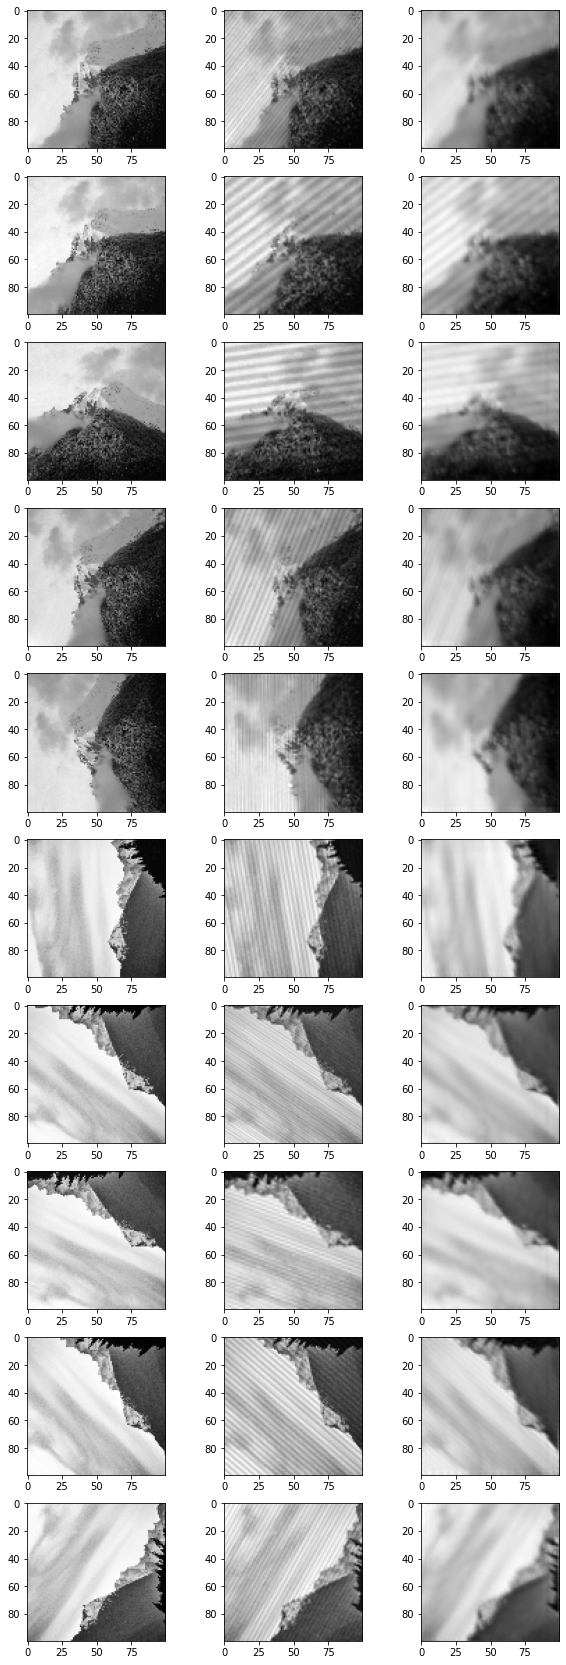

In [6]:
img_to_view = 470

test_output = cnn(test_x[img_to_view:img_to_view+10])
plt.figure(figsize=(10,30))
print(test_y[img_to_view].cpu().data.numpy().squeeze())
for i in range(10):
    plt.subplot(10, 3, i*3+1)
    plt.imshow(test_y[img_to_view+i].cpu().data.numpy().squeeze(), cmap='gray')
    plt.subplot(10, 3, i*3+2)
    plt.imshow(test_x[img_to_view+i].cpu().data.numpy().squeeze(), cmap='gray')
    plt.subplot(10, 3, i*3+3)
    plt.imshow(test_output[i].cpu().data.numpy().squeeze(), cmap='gray')
plt.show()

[[100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]]


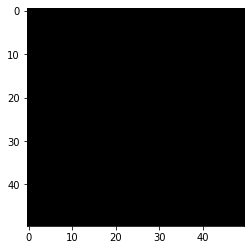

In [7]:
img = np.ones([50, 50])*100
print(img)
plt.imshow(img, cmap='gray')
plt.show()